In [1]:

%load_ext autoreload
%autoreload 2

In [2]:

import os

os.environ["OMP_NUM_THREADS"] = "2"
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["OPENBLAS_NUM_THREADS"] = "2"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import numba as nb
import time
import concurrent.futures
from tqdm import tqdm
from typing import NamedTuple, List, Optional, Tuple, Dict
from py_analysis.config.custom_types import ProcessedSequence, FreeEnergyResult
from py_analysis.config.seq_var import *
from py_analysis.config.gen_var import *
import pickle

from py_analysis.modules.NucFreeEnergy import NucleosomeBreath
from py_analysis.tetramer_fe import process_sequence_padding_and_sliding, energy_per_long_sequence





Source Directory: /home/pol_schiessel/maya620d/pol/Projects/Codebase/NucleosomeMMC
Output Directory: /home/pol_schiessel/maya620d/pol/Projects/Codebase/NucleosomeMMC


In [3]:
T = 298  # Temperature in Kelvin
R = 1.987  # Gas constant in cal/(mol·K)
RT = R * T  # cal/mol
kT_conversion = 1 / RT  # Conversion factor from cal/mol to kT (approx 1.689e-3)

In [4]:
if HARD_CONS:
    filenameconfig = ddGDataSaveParams(
                    nuc_type=NUC_PARAM_TYPE,
                    hangdna_type=HANG_PARAM_TYPE,
                    tetramer_length=TETRAMER_LENGTH,
                    pad_char=PAD_CHAR,
                    constraint="hc"
                )
    
else:
    filenameconfig = ddGDataSaveParams(
            nuc_type=NUC_PARAM_TYPE,
            hangdna_type=HANG_PARAM_TYPE,
            tetramer_length=TETRAMER_LENGTH,
            pad_char=PAD_CHAR,
            constraint="sc"
        )

# Experimental Validation for Nucleosome Free Energy Theory

## Tetra-Histones are bound on DNA

In [5]:
def calculate_free_dna_energy(h_seq:str, dimers:dict):

    kBT = 1
    sum_log_det_l = 0
    N = len(h_seq)-1
    for i in range(N):
        bp = h_seq[i:i+2].upper()
        pstiff = dimers[bp]['stiff']
        det_value = np.linalg.det(pstiff)

        sum_log_det_l = sum_log_det_l + np.log(det_value)


    F_free_DNA_h = kBT * sum_log_det_l / 2

    return F_free_DNA_h


In [6]:
def compute_bp_determinants(stiff):
    
    if stiff.ndim != 2:
        raise ValueError("The stiff matrix must be a 2D numpy array.")
        
    rows, cols = stiff.shape
    if rows != cols:
        raise ValueError("The stiff matrix must be square.")
        
    if rows % 6 != 0:
        raise ValueError("The dimensions of stiff must be a multiple of 6.")
    
    num_bps = rows // 6
    determinants = []
    
    for i in range(num_bps):
        block = stiff[i*6:(i+1)*6, i*6:(i+1)*6]
        det_value = np.linalg.det(block)
        determinants.append(np.log(det_value)-6*np.log(2*np.pi))

    determinants = np.array(determinants)
    return 0.5*determinants



In [7]:
def calculate_gc_content(sequence: str, as_percent: bool = False) -> float:
    sequence = sequence.upper()
    gc_count = sequence.count("G") + sequence.count("C")
    fraction = gc_count / len(sequence) if sequence else 0.0
    return fraction * 100 if as_percent else fraction

In [8]:

nucleosomebreath  = NucleosomeBreath(nuc_method=NUC_PARAM_TYPE, hang_dna_method=HANG_PARAM_TYPE, hang_stiff=True)

# dimers_dict = nucleosomebreath.genstiff_hang.dimers

hang_dna_energy = dict()

for key, value in sequence_dict.items():

    stiff, gs = nucleosomebreath.genstiff_hang.gen_params(value)
    # print(stiff)
    # logdet_sign, logdet = np.linalg.slogdet(stiff)

    hang_dna_energy[key] = compute_bp_determinants(stiff)






Using nucleosome method: hybrid
Using hang DNA method: md
Using hang stiffness: True


In [9]:
# gs_, stiff_ = cgnaplus_fn("A"*45)
# sum(compute_bp_determinants(stiff_))

In [10]:
pad_seq_energy = dict({"AA":0, "AT":0, "TT":0, "TA":0, "CG":0, "GC":0, "GG":0, "CC":0, "CT":0, "TC":0, "AC":0, "AG":0, "CA":0, "CG":0, "GT":0, "TG":0})


for key, value in pad_seq_energy.items():
   
    stiff, gs = nucleosomebreath.genstiff_nuc.gen_params(key) ##need to use the genstiff_nuc for the padded seq because in nucleomsome energy calculation the pad part used the genstiff_nuc parameters

    pad_seq_energy[key] = compute_bp_determinants(stiff)[0]



In [11]:
sum_hang_dna_energy = {key: np.sum(val) for key, val in hang_dna_energy.items()}
sum_hang_dna_energy
SUM_FREE_df = pd.DataFrame(list(sum_hang_dna_energy.items()), columns=['id', 'F_C_freeDNA'])

In [12]:
SUM_FREE_df

,id,F_C_freeDNA
0,IAT,1866.852956
1,IGC,1870.860994
2,NOTA,1875.884541
3,TG_1989,1873.220971
4,TG_T,1872.224722
5,TRGC,1877.868150
6,TR_5,1874.284911
7,TTT,1875.213748
8,d1,1041.415403
9,d2,1036.522082


In [13]:
gc_content_dict = {}
for seq_id, seq in sequence_dict.items():
    gc_content_dict[seq_id] = calculate_gc_content(seq, True)


In [14]:
gc_content_dict

{'IAT': 55.688622754491014,
 'IGC': 55.688622754491014,
 'NOTA': 55.688622754491014,
 'TG_1989': 55.688622754491014,
 'TG_T': 61.67664670658682,
 'TRGC': 61.67664670658682,
 'TR_5': 52.69461077844312,
 'TTT': 55.688622754491014,
 'd1': 55.91397849462365,
 'd2': 66.66666666666666,
 'c1': 56.4625850340136,
 'd3': 65.59139784946237,
 'd4': 55.91397849462365,
 'd5': 66.66666666666666,
 'e1': 56.4625850340136,
 'e2': 53.76344086021505,
 'e3': 43.01075268817204,
 'three_four': 58.68263473053892,
 'two_zero': 64.67065868263472,
 'c2': 48.97959183673469,
 'c3': 50.617283950617285,
 'TG_1990': 55.688622754491014,
 'ANISO': 52.69461077844312,
 'ANNA': 52.69461077844312,
 'END': 55.688622754491014,
 'EXAT': 52.69461077844312,
 'EXGC': 58.68263473053892,
 'GT': 52.69461077844312}

In [15]:
### Make sure this generates the same sequences as in the NucFreeEnergy_Exper_val.py script. Otherwise a potential wrong analysis.

processed_sequences = {}
for name, seq in sequence_dict.items():
    processed_sequences[name] = process_sequence_padding_and_sliding(seq=seq, 
                                                                     seq_id=name,
                                                                     window_length=TETRAMER_LENGTH, 
                                                                     final_length=NUC_LENGTH, 
                                                                     pad_char=PAD_CHAR)



## Calculate the energy for the free DNA for each subid

In [16]:
rows_ps = []
for seq_id, ps_list in processed_sequences.items():
    for ps in ps_list:
        rows_ps.append({
            "id": seq_id,
            "subid": ps.subid,
            "start_site": ps.start_site,
            "end_site": ps.end_site
        })

# Create a DataFrame for the processed sequences' metadata.
df_ps = pd.DataFrame(rows_ps)

In [17]:
final_length = NUC_LENGTH
window_length = TETRAMER_LENGTH
# Calculate the total padding done to the sequence
total_pad = final_length - window_length
left_pad = total_pad // 2
right_pad = total_pad - left_pad

In [18]:
df_ps["lpad_len"]= left_pad
df_ps["rpad_len"]= right_pad
df_ps["pad_nuc"] = PAD_CHAR

In [19]:
df_ps

,id,subid,start_site,end_site,lpad_len,rpad_len,pad_nuc
0,IAT,IAT_0,0,56,45,45,A
1,IAT,IAT_1,1,57,45,45,A
2,IAT,IAT_2,2,58,45,45,A
3,IAT,IAT_3,3,59,45,45,A
4,IAT,IAT_4,4,60,45,45,A
...,...,...,...,...,...,...,...
2439,GT,GT_106,106,162,45,45,A
2440,GT,GT_107,107,163,45,45,A
2441,GT,GT_108,108,164,45,45,A
2442,GT,GT_109,109,165,45,45,A


In [20]:

def calc_excluded_energy(energy_array: np.ndarray, start_site: int, end_site: int) -> float:
    
    left_sum = energy_array[:start_site].sum() if start_site > 0 else 0.0
    right_sum = energy_array[end_site+1:].sum() if end_site+1 < len(energy_array) else 0.0
    return left_sum + right_sum

In [21]:

def add_freedna_energy(df: pd.DataFrame, hang_dna_energy: Dict[str, np.ndarray]) -> pd.DataFrame:
    

    for index, row in df.iterrows():
        energy_array = hang_dna_energy.get(row['id'])
        if energy_array is not None:
            excluded_energy = calc_excluded_energy(energy_array, row['start_site'], row['end_site'])
            df.at[index, 'F_Hangdna'] = excluded_energy
        else:
            df.at[index, 'F_Hangdna'] = None

    return df
##Since the dataframes are mutable, we can add the energy to the df_ps dataframe directly inside the function.
add_freedna_energy(df_ps, hang_dna_energy)

,id,subid,start_site,end_site,lpad_len,rpad_len,pad_nuc,F_Hangdna
0,IAT,IAT_0,0,56,45,45,A,1225.335652
1,IAT,IAT_1,1,57,45,45,A,1224.963499
2,IAT,IAT_2,2,58,45,45,A,1225.688015
3,IAT,IAT_3,3,59,45,45,A,1225.837992
4,IAT,IAT_4,4,60,45,45,A,1225.837992
...,...,...,...,...,...,...,...,...
2439,GT,GT_106,106,162,45,45,A,1233.735581
2440,GT,GT_107,107,163,45,45,A,1233.525788
2441,GT,GT_108,108,164,45,45,A,1233.605433
2442,GT,GT_109,109,165,45,45,A,1232.880918


In [22]:
lpad_energy = sum(pad_seq_energy[PAD_CHAR*2] for _ in range(left_pad-1))
rpad_energy = sum(pad_seq_energy[PAD_CHAR*2] for _ in range(right_pad-1))
df_ps["Pad_energy"] =lpad_energy + rpad_energy
# df_ps["Pad_energy"] = sum(compute_bp_determinants(stiff_))*2

print("Left pad free energy:", lpad_energy)
print("Right pad free energy:", rpad_energy)

Left pad free energy: 504.4306664656479
Right pad free energy: 504.4306664656479


## Load the Pickle file containing the free energy from the theory calculation 

### Output of tetramer_fe.py 

In [23]:


pkl_filepath = RESULTS_DIR / "pklfiles" / f"{filenameconfig.ddG_filename(long_name=False)}.pkl"
with open(pkl_filepath, "rb") as f:
    results_all = pickle.load(f)

print(results_all)

{'d1': [FreeEnergyResult(F=np.float64(1779.8415805920315), F_entropy=np.float64(1750.4029759537489), F_enthalpy=np.float64(29.43860463828254), F_freedna=np.float64(1668.6145009116644), id='d1', subid='d1_0'), FreeEnergyResult(F=np.float64(1782.3769060767504), F_entropy=np.float64(1749.6308572539956), F_enthalpy=np.float64(32.74604882275485), F_freedna=np.float64(1668.1393014441078), id='d1', subid='d1_1'), FreeEnergyResult(F=np.float64(1784.03151565517), F_entropy=np.float64(1750.0433236626695), F_enthalpy=np.float64(33.98819199250047), F_freedna=np.float64(1668.4813415354001), id='d1', subid='d1_2'), FreeEnergyResult(F=np.float64(1782.1921526663075), F_entropy=np.float64(1749.8077533487506), F_enthalpy=np.float64(32.384399317556834), F_freedna=np.float64(1668.2229245255407), id='d1', subid='d1_3'), FreeEnergyResult(F=np.float64(1779.3749229180985), F_entropy=np.float64(1749.9961281398807), F_enthalpy=np.float64(29.378794778217653), F_freedna=np.float64(1668.524513126859), id='d1', sub

In [24]:

rows = []
# Loop over each sequence id and its list of results.
for seq_id, results in results_all.items():
    for res in results:
        # Convert each NamedTuple (or similar tuple-like object) to a dictionary.
        # If your NamedTuple has an _asdict() method, you can use that.
        res_dict = res._asdict() if hasattr(res, "_asdict") else dict(res)
        res_dict["sequence_id"] = seq_id  # add the sequence id from the dictionary
        rows.append(res_dict)

# Create a DataFrame from the row dicts.
df_results = pd.DataFrame(rows)

# Display the first few rows of the resulting DataFrame.
print(df_results.head())

             F    F_entropy  F_enthalpy    F_freedna  id subid sequence_id
0  1779.841581  1750.402976   29.438605  1668.614501  d1  d1_0          d1
1  1782.376906  1749.630857   32.746049  1668.139301  d1  d1_1          d1
2  1784.031516  1750.043324   33.988192  1668.481342  d1  d1_2          d1
3  1782.192153  1749.807753   32.384399  1668.222925  d1  d1_3          d1
4  1779.374923  1749.996128   29.378795  1668.524513  d1  d1_4          d1


In [26]:
merged_df = pd.merge(df_results, 
                     df_ps[['subid', 'F_Hangdna', 'Pad_energy']], 
                     on="subid",
                       how="left")


merged_df = pd.merge(merged_df, 
                     SUM_FREE_df[['id', 'F_C_freeDNA']], 
                     on="id",
                       how="left")


In [27]:
merged_df['tetramer_F'] = merged_df['F']-merged_df['Pad_energy']+merged_df['F_Hangdna']-merged_df['F_C_freeDNA']

In [28]:
if select_min_F:
    # Select the tetramer with the minimum free energy for each sequence id
    merged_df = merged_df.loc[merged_df.groupby("id")["tetramer_F"].idxmin()].copy()


In [29]:
merged_df["min_id"] = merged_df.groupby("id")["tetramer_F"].transform("min")
merged_df["min_reduced_F"] = merged_df["tetramer_F"] - merged_df["min_id"]

In [31]:
# Calculate rba_theory for each sequence S.
# The equation is:
#   rba_theory,S = [exp(-ΔG_min,S / RT) / exp(-ΔG_min,ref / RT)] *
#                  [Σ_i exp(-(ΔG_S,i - ΔG_min,S) / RT) / Σ_j exp(-(ΔG_ref,j - ΔG_min,ref) / RT)]
#
# Here, we take:
#   ΔG_min,S = min_id for sequence S (from merged_df["min_id"]).
#   ΔG_S,i - ΔG_min,S = values in merged_df["min_reduced_F"].
#   ref = get_reference(S) for each sequence S.
#
# We'll group merged_df by "id" and compute for each group:
#   Z_S = sum(exp(- (tetramer_F - min_id) / RT)) = sum(exp(-min_reduced_F / RT))
#   (Note: since min_reduced_F = tetramer_F - min_id)
#
# Then for each sequence S:
#   rba_theory[S] = (exp(-min_id_S/RT) / exp(-min_id_ref/RT)) * (Z_S / Z_ref)
#
# Make sure RT is defined (from cell index 1).

# Grouping the data by sequence id
beta=1
agg_params = {}
for seq_id, group in merged_df.groupby("id"):
    ΔG_min = group["min_id"].iloc[0]  # same for entire group
    Z = np.exp(-beta*group["min_reduced_F"]).sum()  # partition function for this group
    agg_params[seq_id] = {"ΔG_min": ΔG_min, "Z": Z}

# Compute rba_theory for each sequence S
rba_theory = {}
for seq_id, params in agg_params.items():
    ref = get_reference(seq_id)
    if ref not in agg_params:
        raise ValueError(f"Reference sequence '{ref}' not found for id '{seq_id}'.")
    ΔG_min_S = params["ΔG_min"]
    Z_S = params["Z"]
    ΔG_min_ref = agg_params[ref]["ΔG_min"]
    Z_ref = agg_params[ref]["Z"]
    rba_theory_val = np.exp(-beta*(ΔG_min_S-ΔG_min_ref))* (Z_S / Z_ref)
    rba_theory[seq_id] = rba_theory_val

print(rba_theory)

{'ANISO': np.float64(0.174636235223815), 'ANNA': np.float64(0.5440561943689335), 'END': np.float64(0.1461484216895924), 'EXAT': np.float64(0.1417457223388934), 'EXGC': np.float64(0.11049580871918363), 'GT': np.float64(3.263483922091696), 'IAT': np.float64(0.49870059284930296), 'IGC': np.float64(0.09029833580157444), 'NOTA': np.float64(0.0658819011220584), 'TG_1989': np.float64(1.0), 'TG_1990': np.float64(1.0), 'TG_T': np.float64(0.04396621773466088), 'TRGC': np.float64(0.01929906459896993), 'TR_5': np.float64(0.08393550422345523), 'TTT': np.float64(0.1843198353819633), 'c1': np.float64(1.0), 'c2': np.float64(3.8955408724962566), 'c3': np.float64(1.6696296865403295), 'd1': np.float64(1.0), 'd2': np.float64(0.3241399076953752), 'd3': np.float64(0.06180619811611113), 'd4': np.float64(0.08806733200608105), 'd5': np.float64(0.046271542890135284), 'e1': np.float64(1.0), 'e2': np.float64(0.14734051675430682), 'e3': np.float64(0.4292650797143661), 'three_four': np.float64(0.030165046023520714)

In [33]:
sequences_with_data = list(set(list(rba.keys()) + list(energy_sh_tr.keys()) + list(energy_sh_tr_1.keys())))

ΔΔG_exp_kT = dict()
ΔΔG_theory_kT = dict()
labels = []

for S in sequences_with_data:     
    ref = get_reference(S)
    # Experimental ΔΔG
    if S in rba:
        ΔΔG_exp = -RT * np.log(rba[S])  # cal/mol
    elif S in energy_sh_tr:
        ΔΔG_exp = energy_sh_tr[S]  # cal/mol
    elif S in energy_sh_tr_1:
        ΔΔG_exp = energy_sh_tr_1[S]  # cal/mol
    else:
        continue
    ΔΔG_exp_kT[S]= ΔΔG_exp * kT_conversion  # Convert to kT

    # # Theoretical ΔΔG
    
    ΔΔG_theory = -beta * np.log(rba_theory[S]) 
    ΔΔG_theory_kT[S]= ΔΔG_theory
    
    # labels.append(S)

In [ ]:
ΔΔG_exp_kT_df = pd.DataFrame(ΔΔG_exp_kT.items(), columns=['id', 'ΔΔG_exp_kT'])

ΔΔG_theory_kT_df = pd.DataFrame(ΔΔG_theory_kT.items(), columns=['id', 'ΔΔG_theory_kT'])
merged_ddG_df = pd.merge(ΔΔG_exp_kT_df, ΔΔG_theory_kT_df, on="id")


### Saving the delta delta G values from the experiment and model

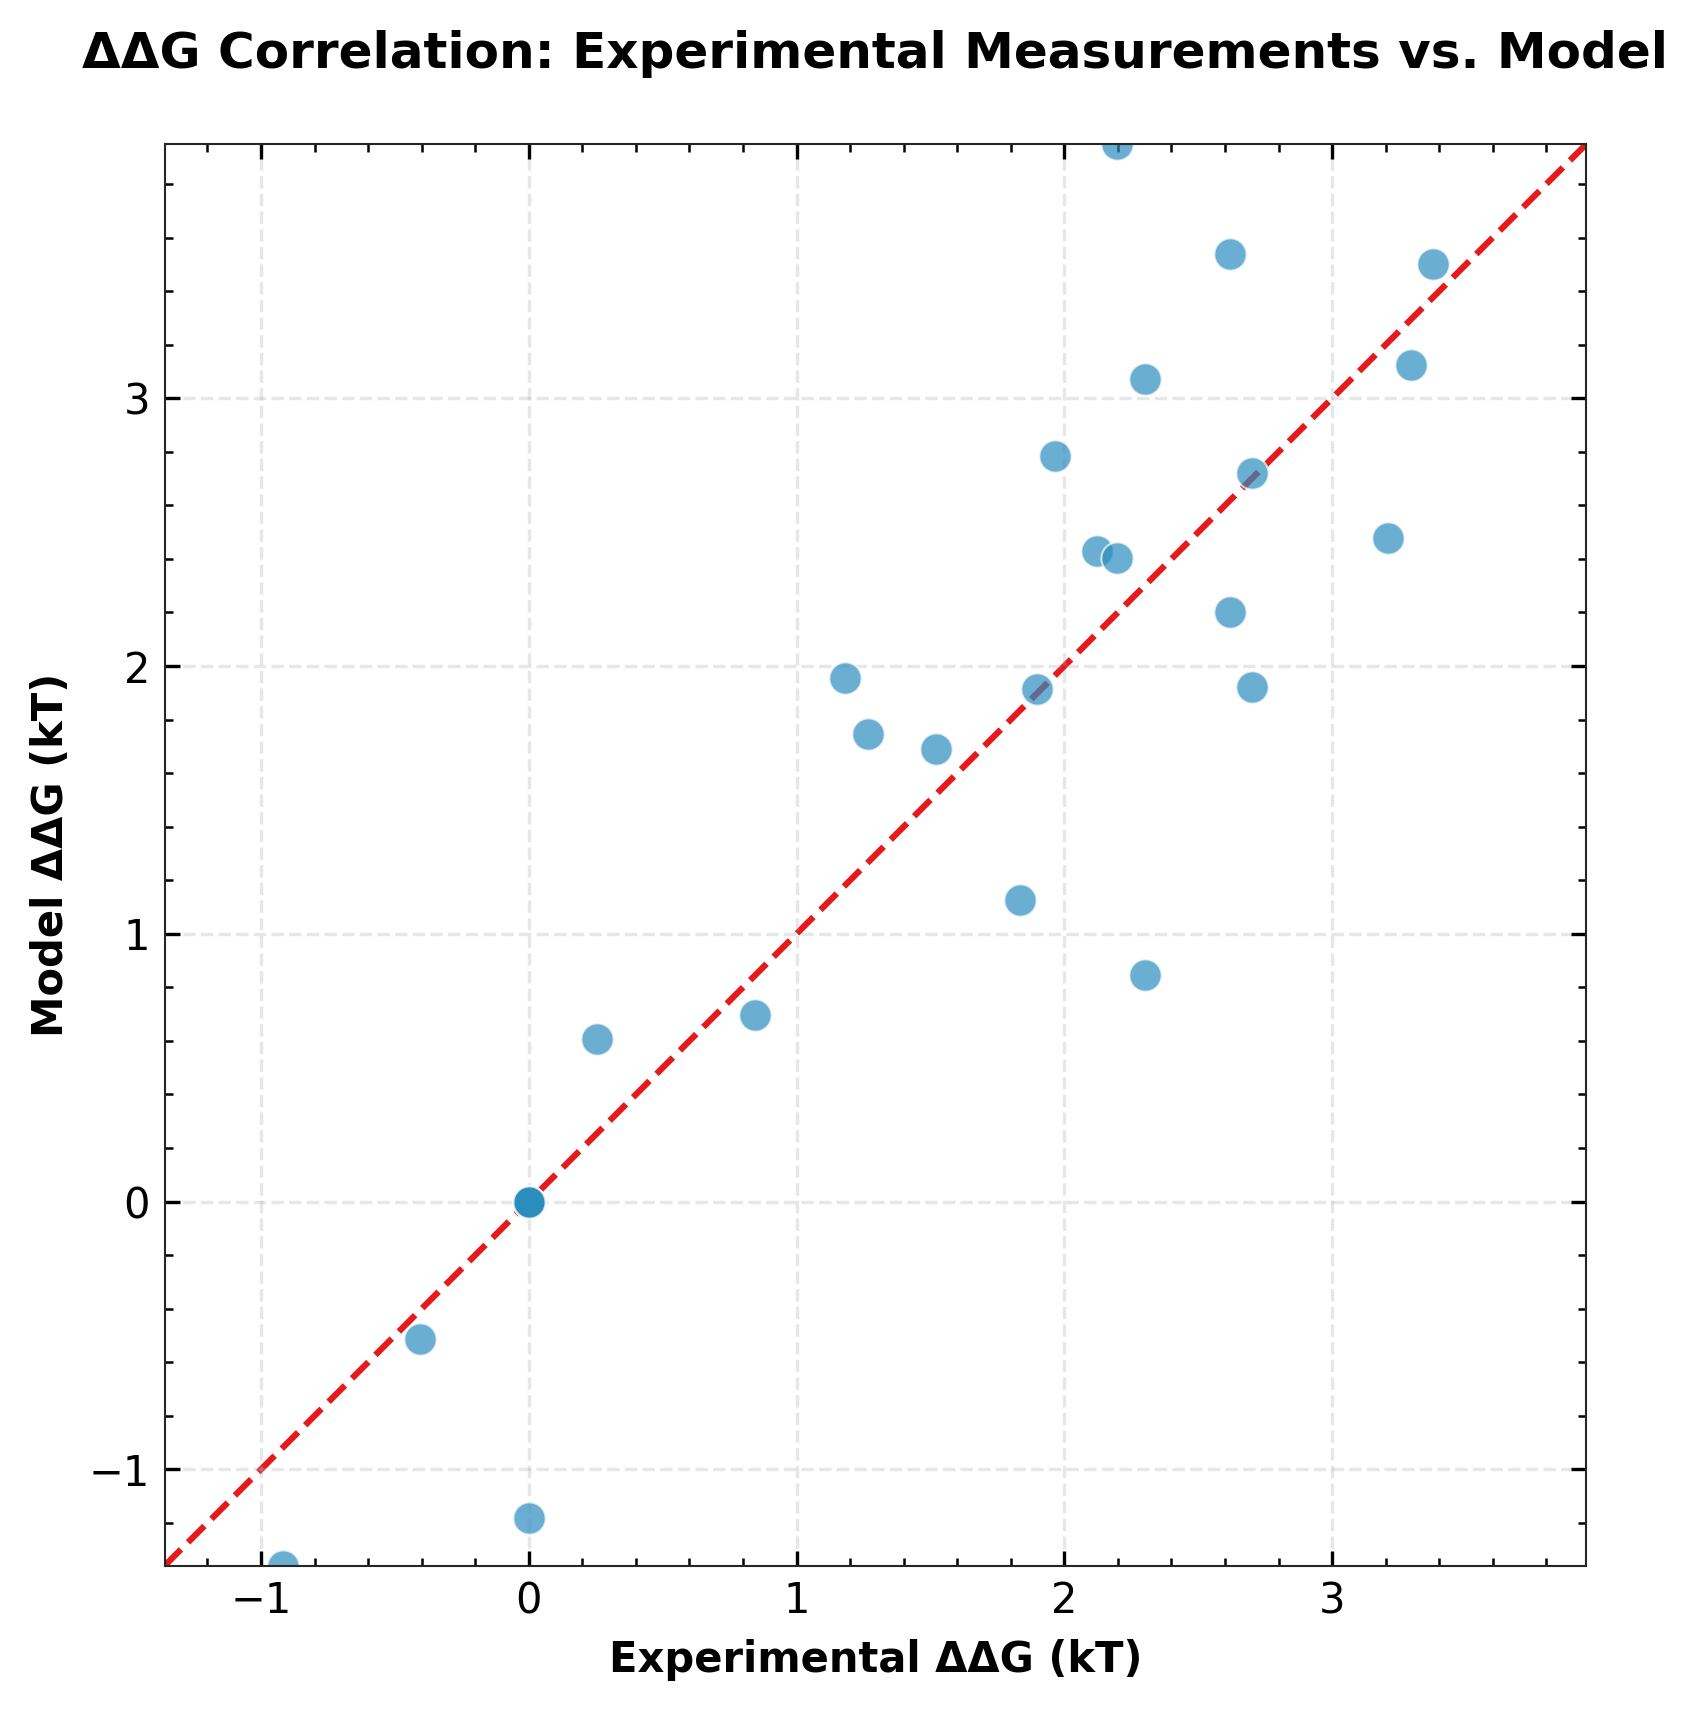

<Figure size 600x600 with 0 Axes>

In [37]:



merged_ddG_df.to_csv(RESULTS_DIR / "nbfiles/nucfe" / f"{filenameconfig.ddG_filename(long_name=False)}.txt", sep="\t", index=False)

# Create figure with tight layout
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
fig.tight_layout(pad=3)

plt.figure(figsize=(6, 6))
sc = ax.scatter(
    x="ΔΔG_exp_kT",
    y="ΔΔG_theory_kT",
    data=merged_ddG_df,
    c='#2b8cbe',  # Professional blue color
    s=60,         # Larger markers
    alpha=0.7,    # Slight transparency
    edgecolor='w', # White borders
    linewidth=0.5,
    zorder=2
)
min_val = min(merged_ddG_df["ΔΔG_exp_kT"].min(), merged_ddG_df["ΔΔG_theory_kT"].min())
max_val = max(merged_ddG_df["ΔΔG_exp_kT"].max(), merged_ddG_df["ΔΔG_theory_kT"].max())
lims = [min_val, max_val]
ax.plot(lims, lims, c='#e41a1c', ls='--', lw=1.5, zorder=1, label='')

# Format axes
ax.set(
    xlabel='Experimental ΔΔG (kT)',
    ylabel='Model ΔΔG (kT)',
    xlim=lims,
    ylim=lims,
    aspect='equal', 
)
# Add grid and legend
ax.grid(True, alpha=0.3, ls='--')
# ax.legend(loc='lower right', frameon=True, framealpha=0.9)

# Use proper scientific formatting
ax.ticklabel_format(style='sci', axis='both', scilimits=(-2,2))
ax.xaxis.get_offset_text().set_fontsize(10)
ax.yaxis.get_offset_text().set_fontsize(10)

# Add minor ticks
ax.minorticks_on()
ax.tick_params(axis='both', which='both', direction='in', 
               top=True, right=True, labelsize=10)

# Add unit to axis labels if needed
ax.set_xlabel(ax.get_xlabel(), fontweight='bold')
ax.set_ylabel(ax.get_ylabel(), fontweight='bold')

ax.set_title("ΔΔG Correlation: Experimental Measurements vs. Model\n", 
            fontsize=12, pad=5, fontweight='bold')


for ext in ["svg", "png"]:
    plt.savefig(RESULTS_DIR / "nbfigs/nucfe" /  f"{filenameconfig.ddG_filename(long_name=False)}.{ext}", dpi=300)

plt.show()